In [1]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import mlflow, os, nltk, random, re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

i = 1

In [2]:
nltk.download('words')
nltk.download('punkt')

from nltk.corpus import words

vocabulary = words.words()

[nltk_data] Downloading package words to
[nltk_data]     /Users/thanawatthongpia/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thanawatthongpia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Convert GloVe vectors to word2vec format
# from gensim.scripts.glove2word2vec import glove2word2vec

# glove_file = "src/glove.42B.300d.txt"
# temp_word2vec_file = "src/w2v.42B.300d.txt"
# glove2word2vec(glove_file, temp_word2vec_file)

In [4]:
def normalize_text(text):

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|\S+\.com\S+", "", text)

    # Remove newline and tab characters
    text = re.sub(r"\n|\t", " ", text)

    # Remove Unicode characters
    text = re.sub(r"\\u\w+", "", text)

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text)

    return text

In [5]:
def list_of_sentence(text):
    los = []
    sentences = sent_tokenize(text.lower())
    for sen in sentences:
        sen = normalize_text(sen)
        tokensen = word_tokenize(sen)
        los.append(tokensen)
    return los

In [6]:
def import_text_to_list_of_lists(file_path, delimiter='\t'):
    result = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace and newlines
            sublist = line.split(delimiter)
            result.append(sublist)
    return result

In [7]:
def CreateW2V_Model(w2v_file_name, pre_train_file, vectorsize=300, window=5, min_count=1, workers=4):

    folder_path = 'src'
    pre_train_file_path = os.path.join(folder_path, pre_train_file)
    w2v_file_path = os.path.join(folder_path, w2v_file_name)
    RUN_NAME = "Create Word2Vec Model"

    if mlflow.active_run():
        mlflow.end_run()
    
    with mlflow.start_run(run_name=RUN_NAME):
        # Check exist model
        if os.path.isfile(pre_train_file_path):
            # Load word vectors
            GloVe_vectors = KeyedVectors.load(pre_train_file_path)
        else:
            GloVe_vectors = KeyedVectors.load_word2vec_format(w2v_file_path, binary=False)

        # Initialize a Gensim Word2Vec model
        model = Word2Vec(vector_size=vectorsize, window=window, min_count=min_count, workers=workers)
        # Set the vocabulary and vectors of the model
        model.build_vocab_from_freq(GloVe_vectors.key_to_index)
        model.wv.key_to_index = GloVe_vectors.key_to_index
        model.wv.vectors = GloVe_vectors.vectors
        model.wv.index_to_key = GloVe_vectors.index_to_key
        
        if not os.path.isfile(pre_train_file_path):
            model.wv.save(pre_train_file_path) 

        # Log parameters
        mlflow.log_param("vectorsize", vectorsize)
        mlflow.log_param("window", window)
        mlflow.log_param("min_count", min_count)
        mlflow.log_param("workers", workers)

        # Log model artifact
        mlflow.log_artifact(pre_train_file_path)
        
        return model

In [8]:
os.path.isfile(os.path.join('src', "GloVe.wordvectors"))

True

In [9]:
def test_Accuracy(model , test_file_path):
    with open(test_file_path, 'r') as file:
        lines = file.readlines()
    total_questions = 0
    correct_predictions = 0
    random_amount = 1000
    random.seed(42)
    for line in random.sample(lines, random_amount):
        if line.startswith(':'):
            continue  # Skip comment lines and category headers
        question, expected_answer = [word.lower() for word in line.split()[:2]]
        choices = [word.lower() for word in line.split()[2:]]
        try:
            predicted_answer = model.wv.most_similar(positive=[question, choices[1]], negative=[expected_answer])[0][0]
            if predicted_answer == choices[0]:
                correct_predictions += 1
        except KeyError:
            continue  # Skip questions with out-of-vocabulary words

        total_questions += 1

    accuracy = correct_predictions / total_questions * 100
    return accuracy

In [10]:
def train_with_corpus(model, new_corpus, epochs):
    RUN_NAME = f"train round {i}"
    if mlflow.active_run():
        mlflow.end_run()
        
    with mlflow.start_run(run_name=RUN_NAME):
        # Update the vocabulary with new words
        model.build_vocab(new_corpus, update=True)
        model.train(new_corpus, total_examples=len(new_corpus), epochs=epochs)

        # Log parameters
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("train round", i)
        # Log model artifact
        # mlflow.sklearn.log_model(model, "word2vec_model")

        accuracy = test_Accuracy(model,'src/questions-words.txt' )
        mlflow.log_param("accuracy", accuracy)
        return model

In [11]:
def plot_vec(model):
    
    vocabulary = words.words()
    all_words = []
    vectors = []
    vocabs = list(set(vocabulary) & set(model.wv.key_to_index.keys()))
    random.seed(42)
    random_amount = 100
    for word in random.sample(vocabs, random_amount):
        all_words.append(word)
        vectors.append(model.wv[word])
        
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(np.array(vectors))

    #########   PLOT CHART    #######
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(all_words):
        x, y = vectors_tsne[i]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), alpha=0.5, fontsize=8)

    plt.title("t-SNE Visualization of Word2Vec Embeddings")
    plt.show()

In [12]:
model = CreateW2V_Model("w2v.42B.300d.txt",'GloVe.wordvectors')

In [13]:
model.wv.most_similar("apple", topn=5)

[('iphone', 0.7339416146278381),
 ('ipad', 0.7129027247428894),
 ('apples', 0.6433200836181641),
 ('blackberry', 0.6380701661109924),
 ('ipod', 0.6341225504875183)]

In [14]:
# test corpus

# new_corpus = [
#     ['apple', 'fruit', 'red'],
#     ['banana', 'fruit', 'yellow'],
#     ['orange', 'fruit', 'orange'],
#     ['carrot', 'vegetable', 'orange'],
#     ['broccoli', 'vegetable', 'green'],
#     ['spinach', 'vegetable', 'green'],
#     ['tomato', 'fruit', 'red'],
#     ['cucumber', 'vegetable', 'green'],
#     ['strawberry', 'fruit', 'red']
# ]

# with open('src/Moby-Dick.txt', 'r') as file:
#     text = file.read()
# los_new_corpus = list_of_sentence(text)

In [15]:
# for time in range(5):
#     model = train_with_corpus(model,new_corpus,1000)
#     i+=1
#     model.wv.most_similar("apple", topn=5)

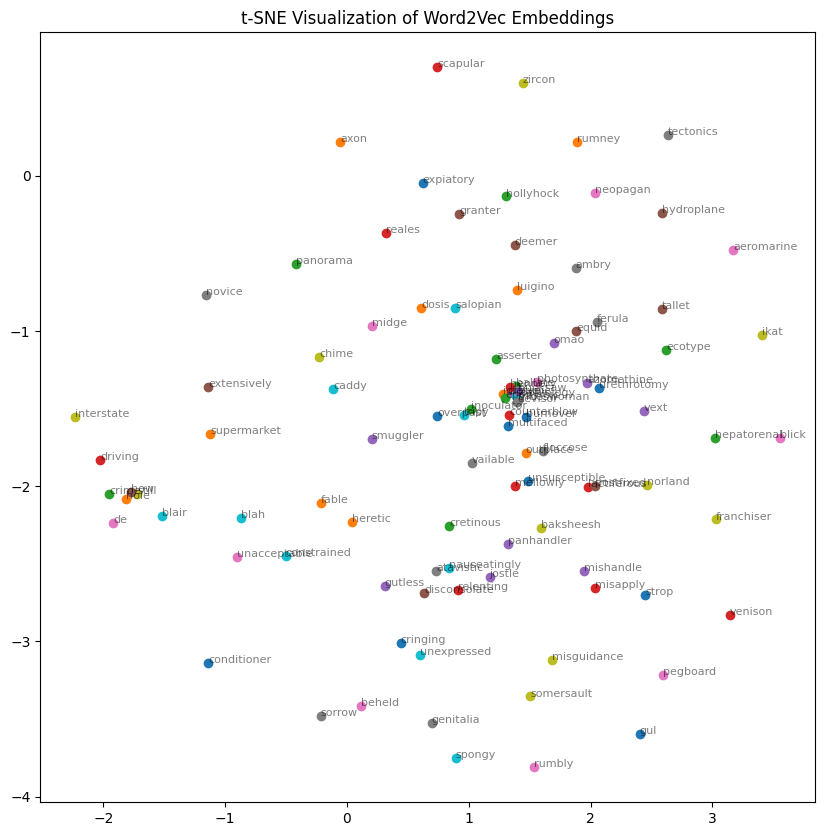

In [16]:
plot_vec(model)

In [17]:
# test_Accuracy(model,'src/questions-words.txt' )

In [18]:
techx_corpus = import_text_to_list_of_lists('src/TechX_corpus.txt', delimiter='\t')

In [19]:
key = 'scb'
try:
    model.wv[key]
    print(model.wv.most_similar(key,topn=5))
except KeyError:
    print(f"{key} not found")

[('aic', 0.3304489850997925), ('gsc', 0.32839545607566833), ('m&i', 0.3262021243572235), ('laurentian', 0.32590141892433167), ('iob', 0.3192133605480194)]


In [20]:
model = train_with_corpus(model,techx_corpus,epochs=100)

In [21]:
try:
    model.wv[key]
    print(model.wv.most_similar(key,topn=5))
except KeyError:
    print(f"{key} not found")

[('21stfloor', 0.9353978037834167), ('pointx', 0.9321911334991455), ('scbtechx.ioor', 0.9282264113426208), ('innovestx', 0.9277396202087402), ('ekyc', 0.9276942610740662)]


In [22]:
model.wv.most_similar("techx",topn=10)

[('innovestx', 0.9346820116043091),
 ('ekyc', 0.9342429041862488),
 ('21stfloor', 0.9341257214546204),
 ('pointx', 0.932606041431427),
 ('atcontact', 0.9324731230735779),
 ('scbtechx.ioor', 0.9320839643478394),
 ('attx.dpo', 0.9312519431114197),
 ('scbtechx.io', 0.9310628771781921),
 ('scbxgroup', 0.9303793907165527),
 ('//scbtechx.io', 0.9302679896354675)]